<a href="https://colab.research.google.com/github/andreYoo/Time-series-analysis-anomaly-detection/blob/main/Day1_practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import os
import warnings

plt.style.use('ggplot')


In [44]:
# 구글 드라이브 마운트 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
weather_station_location = pd.read_csv("./drive/MyDrive/study/weather_station_locations.csv")
weather = pd.read_csv("./drive/MyDrive/study/summary_of_weather.csv")
weather_station_location = weather_station_location.loc[:,["WBAN","NAME","STATE/COUNTRY ID","Latitude","Longitude"]]
weather = weather.loc[:,["STA","Date","MeanTemp"]]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7,8,18,25) have mixed types.Specify dtype option on import or set low_memory=False.



In [46]:
weather_station_id = weather_station_location[weather_station_location.NAME == "BINDUKURI"].WBAN
weather_bin = weather[weather.STA == int(weather_station_id)]
weather_bin["Date"] = pd.to_datetime(weather_bin["Date"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



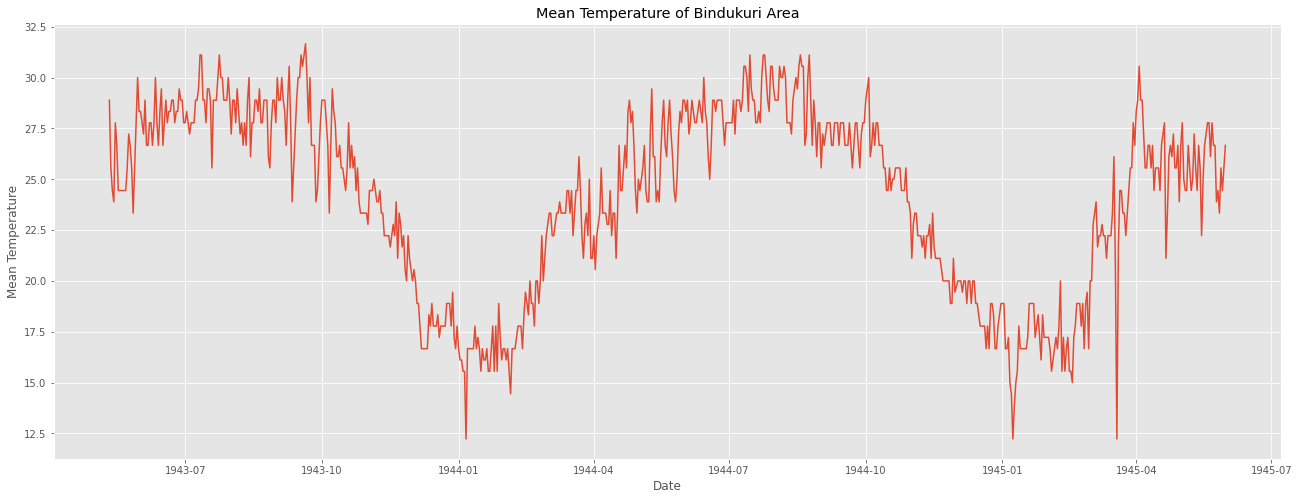

In [47]:
plt.figure(figsize=(22,8))
plt.plot(weather_bin.Date,weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

In [48]:
# lets create time series from weather
timeSeries = weather_bin.loc[:, ["Date","MeanTemp"]]
timeSeries.index = timeSeries.Date
ts = timeSeries.drop("Date",axis=1)
ts

,MeanTemp
Date,
1943-05-11,28.888889
1943-05-12,25.555556
1943-05-13,24.444444
1943-05-14,23.888889
1943-05-15,27.777778
...,...
1945-05-27,23.333333
1945-05-28,25.555556
1945-05-29,24.444444


<Figure size 432x288 with 0 Axes>

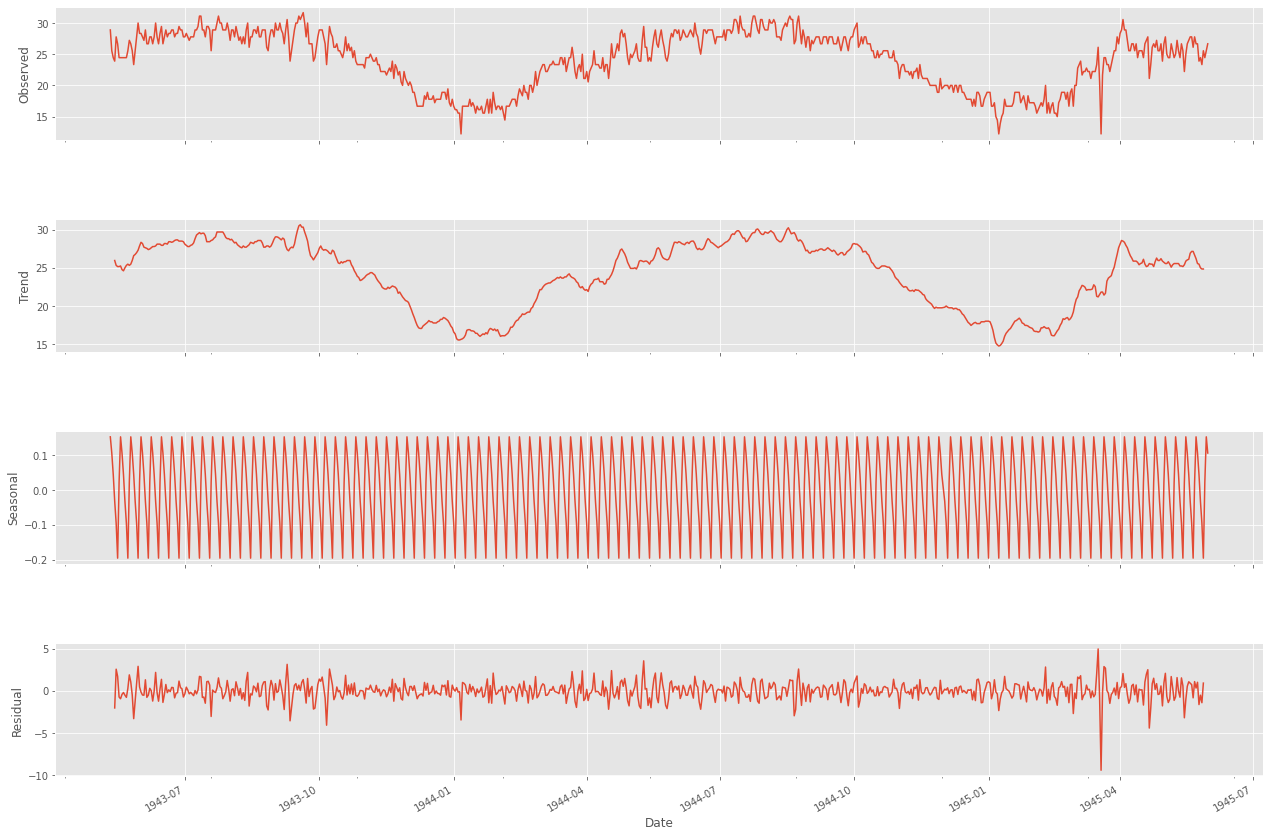

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts['MeanTemp'], model='additive', freq=7)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

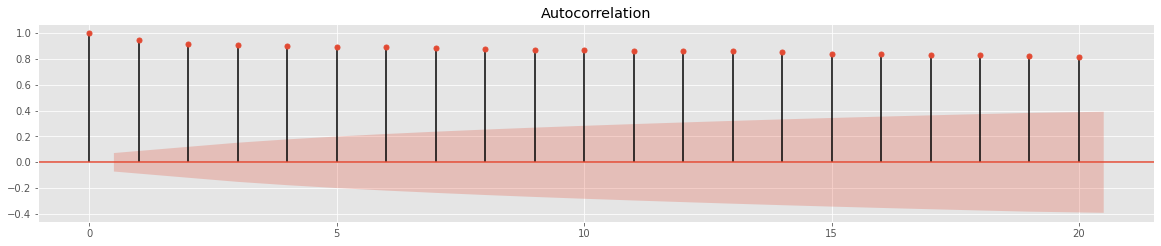

In [50]:
import statsmodels.api as sm
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=20, ax=ax1)

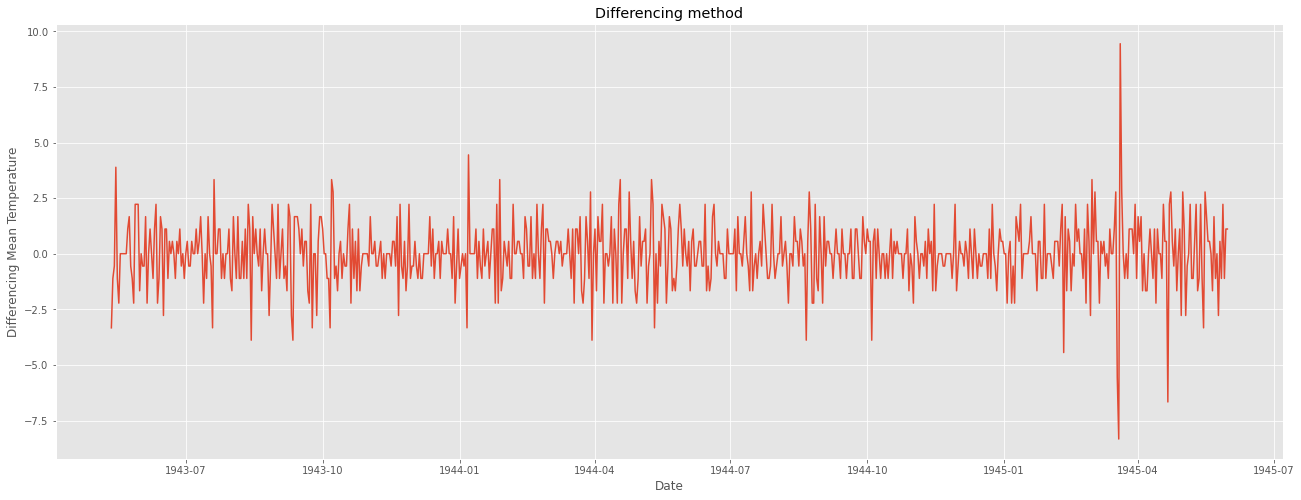

In [51]:
ts_diff = ts - ts.shift()
plt.figure(figsize=(22,8))
plt.plot(ts_diff)
plt.title("Differencing method")
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

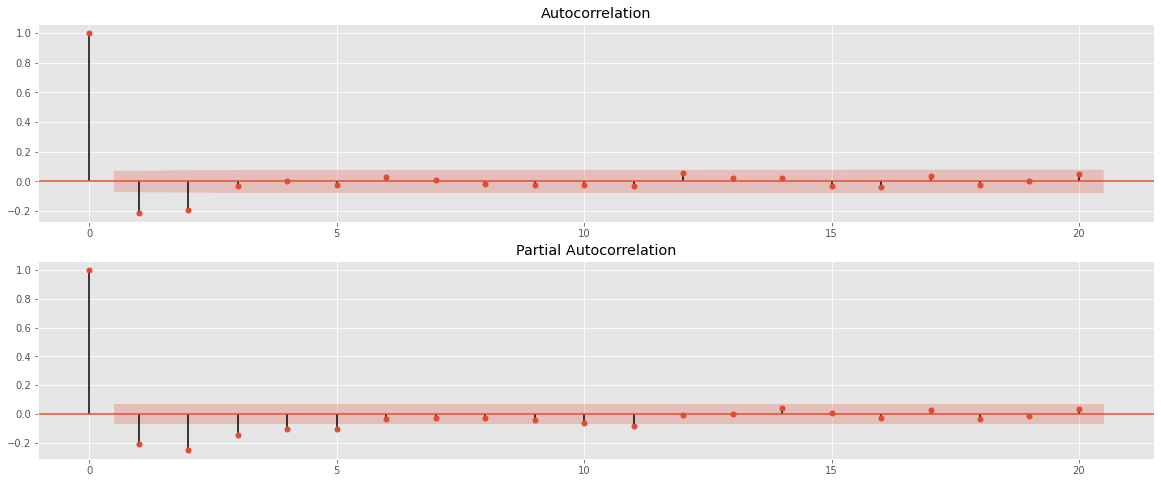

In [52]:
import statsmodels.api as sm
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags=20, ax=ax1) #
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags=20, ax=ax2)# , lags=40

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



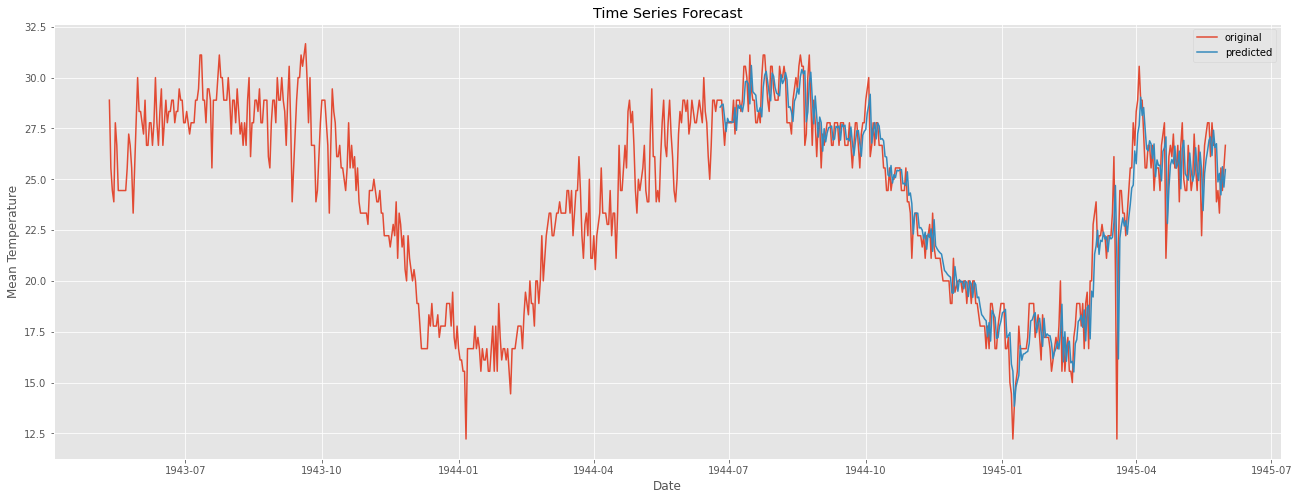

In [53]:
# fit model
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
model = ARIMA(ts, order=(2,1,2))
model_fit = model.fit(disp=0)
# predict
start_index = datetime(1944, 6, 25)
end_index = datetime(1945, 5, 31)
forecast = model_fit.predict(start=start_index, end=end_index,
typ='levels')
# visualization
plt.figure(figsize=(22,8))
plt.plot(weather_bin.Date,weather_bin.MeanTemp,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

No handles with labels found to put in legend.


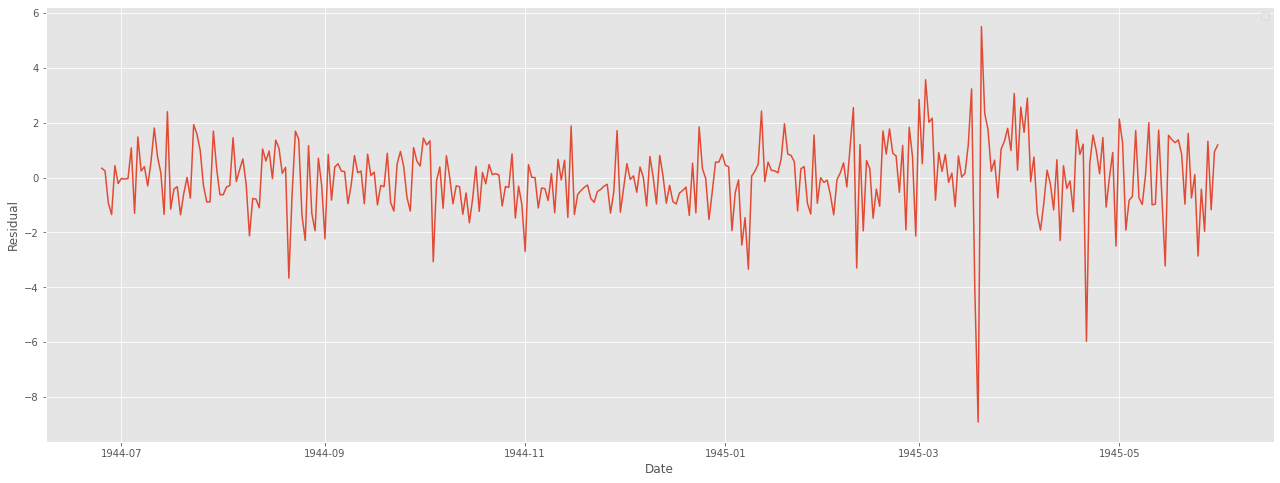

In [54]:
resi = np.array(weather_bin[weather_bin.Date>=start_index].MeanTemp) - np.array(forecast)
plt.figure(figsize=(22,8))
plt.plot(weather_bin.Date[weather_bin.Date>=start_index],resi)
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.show()

In [55]:
from sklearn import metrics


def scoring(y_true, y_pred):
  r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
  # mae = round(metrics.mean_absolute_error(y_true, y_pred),3)
  corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
  mape = round(
  metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
  rmse = round(metrics.mean_squared_error(y_true, y_pred,squared=False), 3)
  df = pd.DataFrame({
    'R2': r2,
    "Corr": corr,
    "RMSE": rmse,
    "MAPE": mape
    },index=[0])
  return df


In [58]:

scoring(np.array(weather_bin[weather_bin.Date>=start_index].MeanTemp),np.array(forecast))

,R2,Corr,RMSE,MAPE
0,91.019,0.954,1.365,4.449
